In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import networkx as nx
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# --------------------------------------
# 1. Load Data
# --------------------------------------
business = pd.read_csv('data_filtered/business_filtered.csv')
checkins = pd.read_csv('data_filtered/checkin_small.csv')
reviews = pd.read_csv('data_filtered/review_small.csv')
tips = pd.read_csv('data_filtered/tips_small.csv')
users = pd.read_csv('data_filtered/user_small.csv')

In [3]:

# --------------------------------------
# 2. Business Clustering
# --------------------------------------
# Vectorize categories
cat_vec = CountVectorizer(token_pattern=r"[^,]+")
cat_mat = cat_vec.fit_transform(business['categories'].fillna(''))

# Extract numeric features
num_feats = business[['stars', 'review_count']].fillna(0)
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_feats)

# Combine
from scipy.sparse import hstack
X_bus = hstack([cat_mat, num_scaled])

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
business['cluster'] = kmeans.fit_predict(X_bus)

# Build similarity graph
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X_bus)
G = nx.Graph()
for i, bid in enumerate(business['name']):
    G.add_node(bid)
# add top-5 edges per node
for i, bid in enumerate(business['name']):
    idx = np.argsort(sim[i])[-6:-1]
    for j in idx:
        G.add_edge(bid, business.at[j, 'name'], weight=sim[i, j])

# Community detection
communities = list(nx.community.greedy_modularity_communities(G))
communities

[frozenset({'3 Sisters Café',
            '400 Beach Seafood & Tap House',
            "Andersen's Danish Bakery & Restaurant",
            "Archie's Giant Hamburgers & Breakfast",
            'Audubon Aquarium of the Americas',
            'Audubon Zoo',
            'Ava',
            'BLO/OUT Blow Dry Bar',
            "Baby's",
            'Bangkokville Thai Cuisine',
            'Bardenay Restaurant & Distillery - Boise',
            'Bella Napoli Pizzeria',
            'Belle Meade Historic Site & Winery',
            'Belmond El Encanto',
            "Benedetto's Ristorante Italiano",
            "Big Al's Deli",
            'Big Woods Speedway',
            'Black Rock Bar & Grill',
            'Blackthorn Pub and Pizza',
            'Blind Owl Brewery',
            'Blue Corn',
            'Blue Willow Restaurant & Gift Shop',
            'Blueberry Hill Restaurant & Bar',
            'Bongos Beach Bar and Grille',
            'Border Cafe',
            'Bouchon',
            '

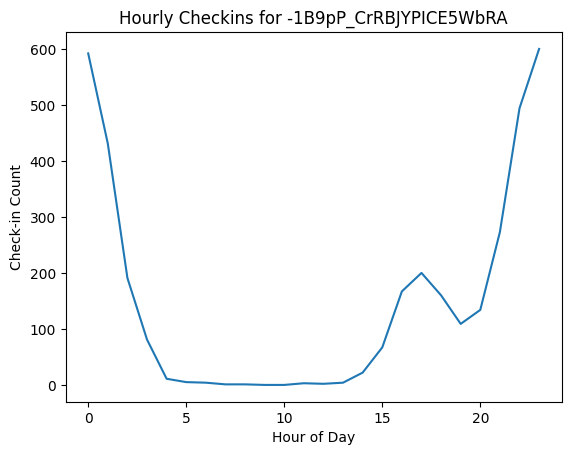

In [4]:
# --------------------------------------
# 3. Check-in Patterns
# --------------------------------------
checkins['datetime'] = pd.to_datetime(checkins['date'] + ' ' + checkins['time'])
checkins['hour'] = checkins['datetime'].dt.hour
hourly = checkins.groupby(['business_id', 'hour']).size().unstack(fill_value=0)
# Plot example for one business
biz = hourly.index[0]
hourly.loc[biz].plot(title=f'Hourly Checkins for {biz}')
plt.xlabel('Hour of Day'); plt.ylabel('Check-in Count'); plt.show()

In [5]:
# --------------------------------------
# 4. Sentiment & Topic Extraction
# --------------------------------------
# Sentiment score
reviews['sentiment'] = reviews['text'].apply(lambda t: TextBlob(t).sentiment.polarity)
# Average sentiment per business
bus_sent = reviews.groupby('business_id')['sentiment'].mean().reset_index()

# Simple keyword extraction (TF-IDF + SVD)
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
T = tfidf.fit_transform(reviews['text'].fillna(''))
svd = TruncatedSVD(n_components=50, random_state=42)
topics = svd.fit_transform(T)
# Append topic features back to reviews for downstream tasks
reviews_topics = pd.concat([
    reviews[['review_id', 'business_id']],
    pd.DataFrame(topics, index=reviews.index)
], axis=1)

In [ ]:

# --------------------------------------
# 5. Predictive Star-Rating Forecast
# --------------------------------------
# Feature engineering for reviews
rev_feat = reviews.merge(users[['user_id', 'average_stars']], on='user_id')
rev_feat = rev_feat.merge(bus_sent, on='business_id', how='left', suffixes=("","_bus"))

# Use text topics too
rev_feat = rev_feat.merge(reviews_topics, on=['review_id','business_id'])

# Target: next review <=2 stars? Binary
rev_feat = rev_feat.sort_values(['business_id','date'])
rev_feat['next_low'] = rev_feat.groupby('business_id')['stars'].shift(-1) <= 2
rev_feat = rev_feat.dropna(subset=['next_low'])

features = ['stars', 'useful', 'funny', 'cool', 'average_stars', 'sentiment'] + list(range(50))
Xr = rev_feat[features]
yr = rev_feat['next_low'].astype(int)
Xr.columns = Xr.columns.astype(str)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(Xr_train, yr_train)
pred = model_lr.predict(Xr_test)
print("Rating-Forecast Accuracy:", accuracy_score(yr_test, pred))
print("Rating-Forecast ROC AUC:", roc_auc_score(yr_test, model_lr.predict_proba(Xr_test)[:,1]))

Rating-Forecast Accuracy: 0.6901986384407349
Rating-Forecast ROC AUC: 0.5971474465551212


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

reviews['date'] = pd.to_datetime(reviews['date'])

# 1) Merge & basic feature engineering
df = reviews.merge(users[['user_id','average_stars']], on='user_id')
df = df.merge(bus_sent, on='business_id', how='left')            # business sentiment

# 1) identify which columns are topics
topic_cols = [c for c in reviews_topics.columns
              if c not in ('review_id','business_id')]

# 2) build a rename dict for _just_ those
rename_map = { c: f"topic_{c}" for c in topic_cols }

# 3) apply it
reviews_topics = reviews_topics.rename(columns=rename_map)

# 4) safe merge
df = df.merge(
    reviews_topics,
    on=['review_id','business_id'],
    how='left'
)
# Add time features
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['business_id','date'])
df['prev_date'] = df.groupby('business_id')['date'].shift(1)
df['days_since_last'] = (df['date'] - df['prev_date']).dt.days.fillna(0)

# Rolling mean of stars for each business (last 3 reviews)
df['stars_roll3'] = df.groupby('business_id')['stars']\
                       .rolling(3, min_periods=1).mean().reset_index(0,drop=True)

# Business‐level metadata
biz_meta = reviews.groupby('business_id').agg(
    biz_avg_stars=('stars','mean'),
    biz_review_count=('stars','count'),
    biz_first_date=('date','min'),
    biz_last_date=('date','max')
).reset_index()
biz_meta['biz_review_span_days'] = (
    biz_meta['biz_last_date'] - biz_meta['biz_first_date']
).dt.days.replace(0,1)
biz_meta['biz_reviews_per_day'] = biz_meta['biz_review_count'] / biz_meta['biz_review_span_days']

df = df.merge(biz_meta.drop(columns=['biz_first_date','biz_last_date']), on='business_id')

# One-hot encode city or category if available
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_df = ohe.fit_transform(business[['city']])
cat_cols = ohe.get_feature_names_out(['city'])
biz_cats = pd.DataFrame(cat_df, columns=cat_cols, index=business.index)
business = pd.concat([business, biz_cats], axis=1)
df = df.merge(business[['business_id'] + list(cat_cols)], on='business_id', how='left')

# 2) Define target
df['next_low'] = df.groupby('business_id')['stars'].shift(-1) <= 2
df = df.dropna(subset=['next_low']).copy()
df['next_low'] = df['next_low'].astype(int)

# 3) Select features
feature_cols = [
    'stars','useful','funny','cool','average_stars','s',
    'days_since_last','stars_roll3',
    'biz_avg_stars','biz_reviews_per_day'
] + list(topic_cols := [c for c in df.columns if c.startswith('topic_')]) \
  + list(cat_cols)

X = df[feature_cols]
y = df['next_low']

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5) Randomized search over RF hyperparameters
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    rf, param_dist, n_iter=10, cv=3,
    scoring='roc_auc', n_jobs=4, random_state=42
)
search.fit(X_train, y_train)

# 6) Calibrate probabilities
best_rf = CalibratedClassifierCV(search.best_estimator_, cv='prefit')
best_rf.fit(X_train, y_train)

# 7) Evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:,1]

print("RF Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

RF Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'max_depth': 10, 'class_weight': None}
Accuracy: 0.6987783269607386
ROC AUC: 0.6772364420234964
